In [37]:
% load_ext autoreload
% autoreload 2

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import sys
sys.path.append('..')
from src.evaluation.evaluator import Evaluator
from src.datasets import SyntheticDataGenerator, MultivariateAnomalyFunction
import main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TODO:
- XOR (Anomaly -> gleichzeitig)
- Ableitung (Geschwindigkeit vs Beschleunigung)
- Invers

## Plot missing results

In [46]:
datasets = [SyntheticDataGenerator.get(f'extreme_1_missing', 42, missing) for missing in np.linspace(0, 0.9, 2)]
detectors = main.get_detectors()[:1] + main.get_detectors()[:0]

In [ ]:
seeds = np.random.randint(low=0, high=2 ** 32 - 1, size=10, dtype="uint32")
print_order = ["dataset", "algorithm", "accuracy", "precision", "recall", "F1-score", "F0.1-score", "auroc"]
rename_columns = [col for col in print_order if col not in ['dataset', 'algorithm']]
results = pd.DataFrame()

for i, seed in enumerate(seeds):
    evaluator = Evaluator(datasets if datasets else get_pipeline_datasets(seed), detectors, seed=seed)
    evaluator.evaluate()
    result = evaluator.benchmarks()
    evaluator.benchmark_results = result
    evaluator.export_results(f'backup-missing-{i}-{seed}', prefix='..')
    del evaluator  # Save memory
    results = results.append(result, ignore_index=True)

N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

2018-07-05 15:50:38 [INFO] src.evaluation.evaluator: Training Recurrent EBM on Syn Extreme Outliers (mis=0.0) with seed 3156909145


100%|███████████████████████████████████████████████| 15/15 [00:08<00:00,  1.87it/s]
100% (1 of 1) |##########################| Elapsed Time: 0:00:10 Time:  0:00:10
N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

2018-07-05 15:50:48 [INFO] src.evaluation.evaluator: Training Recurrent EBM on Syn Extreme Outliers (mis=0.9) with seed 3156909145


 27%|████████████▊                                   | 4/15 [00:02<00:06,  1.74it/s]

In [4]:
avg_results = results.groupby(["dataset", "algorithm"], as_index=False).mean()
avg_results = avg_results[print_order]
avg_results_renamed = avg_results.rename(index=str,
                                         columns=dict([(old_col, old_col + '_avg') for old_col in rename_columns]))

evaluator = Evaluator(datasets if datasets else get_pipeline_datasets(seed), detectors, seed=42)
evaluator.benchmark_results = avg_results

In [5]:
evaluator.export_results('run-pipeline', prefix='..')

2018-07-05 13:42:15 [INFO] src.evaluation.evaluator: Store evaluator results at C:\Users\Thomas\HPI\MP\reports\evaluators\run-pipeline-2018-07-05-134215.pkl


In [42]:
filename = 'run-pipeline-2018-07-05-134215'
evaluator2 = Evaluator(datasets, detectors)
evaluator2.import_results(filename, prefix='..')

2018-07-05 15:30:37 [INFO] src.evaluation.evaluator: Read evaluator results at C:\Users\Thomas\HPI\MP\reports\evaluators\run-pipeline-2018-07-05-134215.pkl


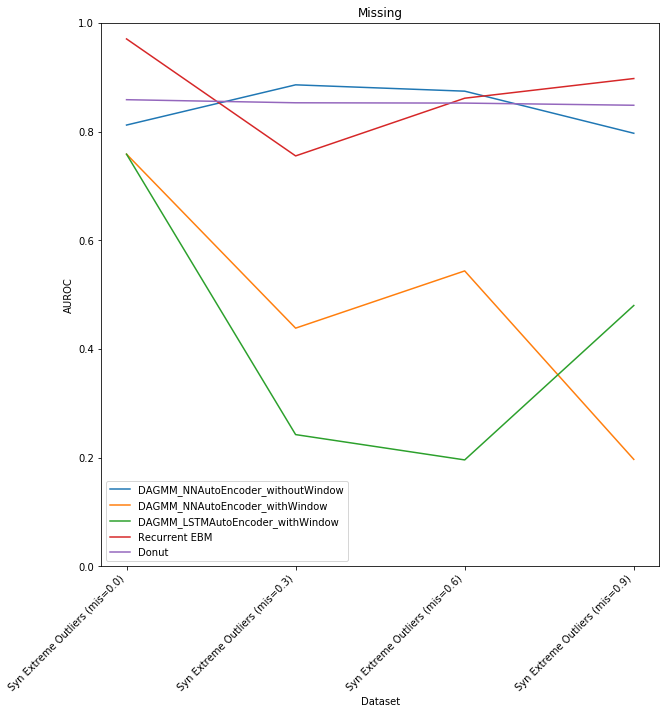

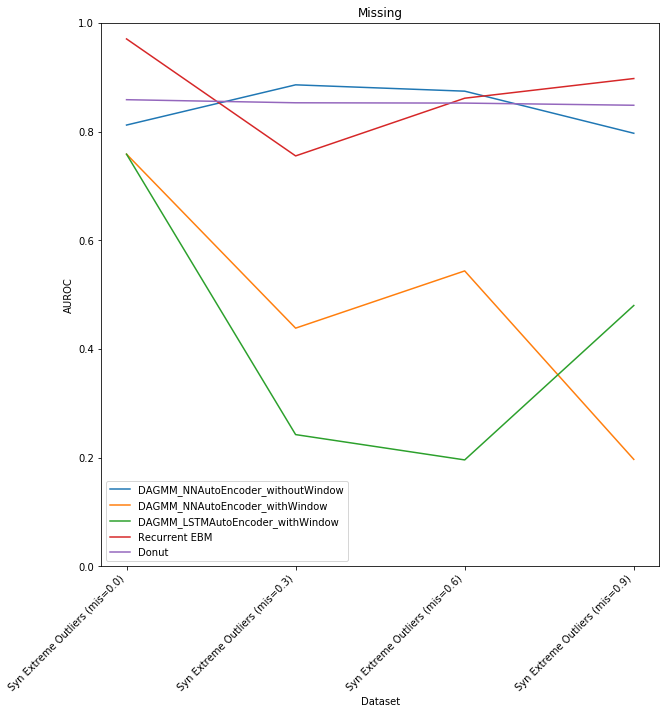

In [44]:
evaluator2.plot_experiment_comparison('Missing')

In [ ]:
evaluator2.benchmark_results['auroc']